<a href="https://colab.research.google.com/github/garychumd/highflow/blob/master/looking%20for%20data%20errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If this is run within Google Colab, we will want to use the GPU to accelerate the cross validation process. To use the GPU to help in cross validation, go to the Runtime menu and go to "Change runtime type" and select GPU and save.

Import the needed libraries and packages for this application.

In [82]:
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import preprocessing
from google.colab import drive

Grant permissions to Google Drive in order to import the data from My Drive

In [83]:
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Reading in the data from Google Drive. The data and the column names are printed out as well. If you are running this from your own drive, be sure to change the filepath to the filepath leading to the csv file. The data from the CSV is stored into a pandas dataframe for convenience and the compatibility with various packages.

In [99]:
data = pd.read_csv(filepath_or_buffer='/content/drive/My Drive/Covid Master 300B.csv', header=1, dtype=str)
print(data.dtypes)
print(list(data.columns.values))
print(data)

Case #                           object
Admission Date                   object
Age                              object
Sex                              object
Ethnicity                        object
                                  ...  
Oxyen sat on highest oxygen.2    object
CPAP / BiPAP.2                   object
Intubation.2                     object
Dead in 30 days                  object
Crash > 4 days                   object
Length: 70, dtype: object
['Case #', 'Admission Date', 'Age', 'Sex', 'Ethnicity', 'Zip code', 'DM', 'HTN', 'Prior MI (Stent CABG)', 'CHF (HFrEF)', 'CHF (HFpEF)', 'OSA', 'Sick Contact hospitalized?', 'Chronic Lung Disease (COPD etc)', 'Immunne suppressed / Transplant', 'Liver Cirrhosis', 'ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy', 'BMI', 'Weight (kg)', 'SBP', 'DBP', 'P', 'R', 'Rom Air Sat', 'Temp (F)', 'Zero to 60 L oxygen', 'Oxyen sat on highest oxygen', 'CPAP / BiPAP', 'Intubation', 'HGBA1c (+/1 100 days)', 'WBC',

Casting values to the appropriate data type and mapping "yes" and "no" to bools. All numeric columns are cast to floats for now to solve the problem of blank entries registered as NaN.

In [100]:
yesNoList = ['DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
'OSA','Sick Contact hospitalized?','Chronic Lung Disease (COPD etc)','Immunne suppressed / Transplant',
'Liver Cirrhosis','ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy',
'CPAP / BiPAP','Intubation','Decadron','Remdesivir','Convalesent Plasma', 'CPAP / BiPAP.1', 'Intubation.1',
'CPAP / BiPAP.2','Intubation.2','Dead in 30 days','Crash > 4 days', 'Zero to 60 L oxygen.2']
convertDict = {'Age':float, 'Zip code':float, 'BMI':float, 'Weight (kg)':float, 'SBP':float, 'DBP':float, 'P':float, 'R':float,
               'Rom Air Sat':float, 'Temp (F)':float, 'Zero to 60 L oxygen':float,
               'Oxyen sat on highest oxygen':float, 'HGBA1c (+/1 100 days)':float, 'WBC':float,
               'HGB':float, 'Creat':float, 'ALT':float, 'TBILI':float, 'CRP': float, 'DDimer': float,
	       'Ferritin':float, 'LDH':float, 'SBP.1':float, 'DBP.1': float, 'P.1':float, 'R.1':float,
               'Temp (F).1':float, 'Zero to 60 L oxygen.1':float, 'Oxyen sat on highest oxygen.1':float,
               'WBC.1':float, 'HGB.1':float, 'Creat.1':float, 'ALT.1':float, 'TBILI.1':float,
               'CRP.1':float, 'DDimer.1':float, 'Ferritin.1':float, 'LDH.1':float, 'DM':bool, 'HTN':bool,
	       'Prior MI (Stent CABG)':bool, 'Chronic Lung Disease (COPD etc)':bool, 'ESRD on HD':bool,
	       'CPAP / BiPAP':bool, 'Intubation':bool, 'Decadron':bool, 'Remdesivir':bool, 'Convalesent Plasma':bool,
	       'CPAP / BiPAP.1':bool, 'Intubation.1':bool, 'Zero to 60 L oxygen.2':bool, 'Intubation.2':bool,
         'Dead in 30 days':bool
               }
for i in yesNoList:
    data[i] = data[i].map({'yes':True, 'no':False, 'Yes':True, 'No':False, 'yes ':True, 'no ':False})
data['Sex'] = data['Sex'].map({'M': False, 'F': True})
data = data.astype(convertDict)
print(data.head(50))

   Case # Admission Date   Age  ...  Intubation.2 Dead in 30 days  Crash > 4 days
0       1      6/14/2020  46.0  ...         False           False             NaN
1       2      6/16/2020  50.0  ...         False           False             NaN
2       3      6/28/2020  85.0  ...         False           False            True
3       4      6/28/2020  82.0  ...         False            True             NaN
4       5       7/1/2020  66.0  ...         False           False             NaN
5       6       7/4/2020  83.0  ...         False           False            True
6       7       7/5/2020  65.0  ...          True           False             NaN
7       8       7/9/2020  45.0  ...         False           False             NaN
8       9      7/10/2020  79.0  ...         False            True             NaN
9      10      7/11/2020  76.0  ...         False           False             NaN
10     11      7/11/2020  55.0  ...          True           False             NaN
11     12      7

For some datafields, we can create histograms which are useful for finding extraneous data points in addition to being good for visualization.

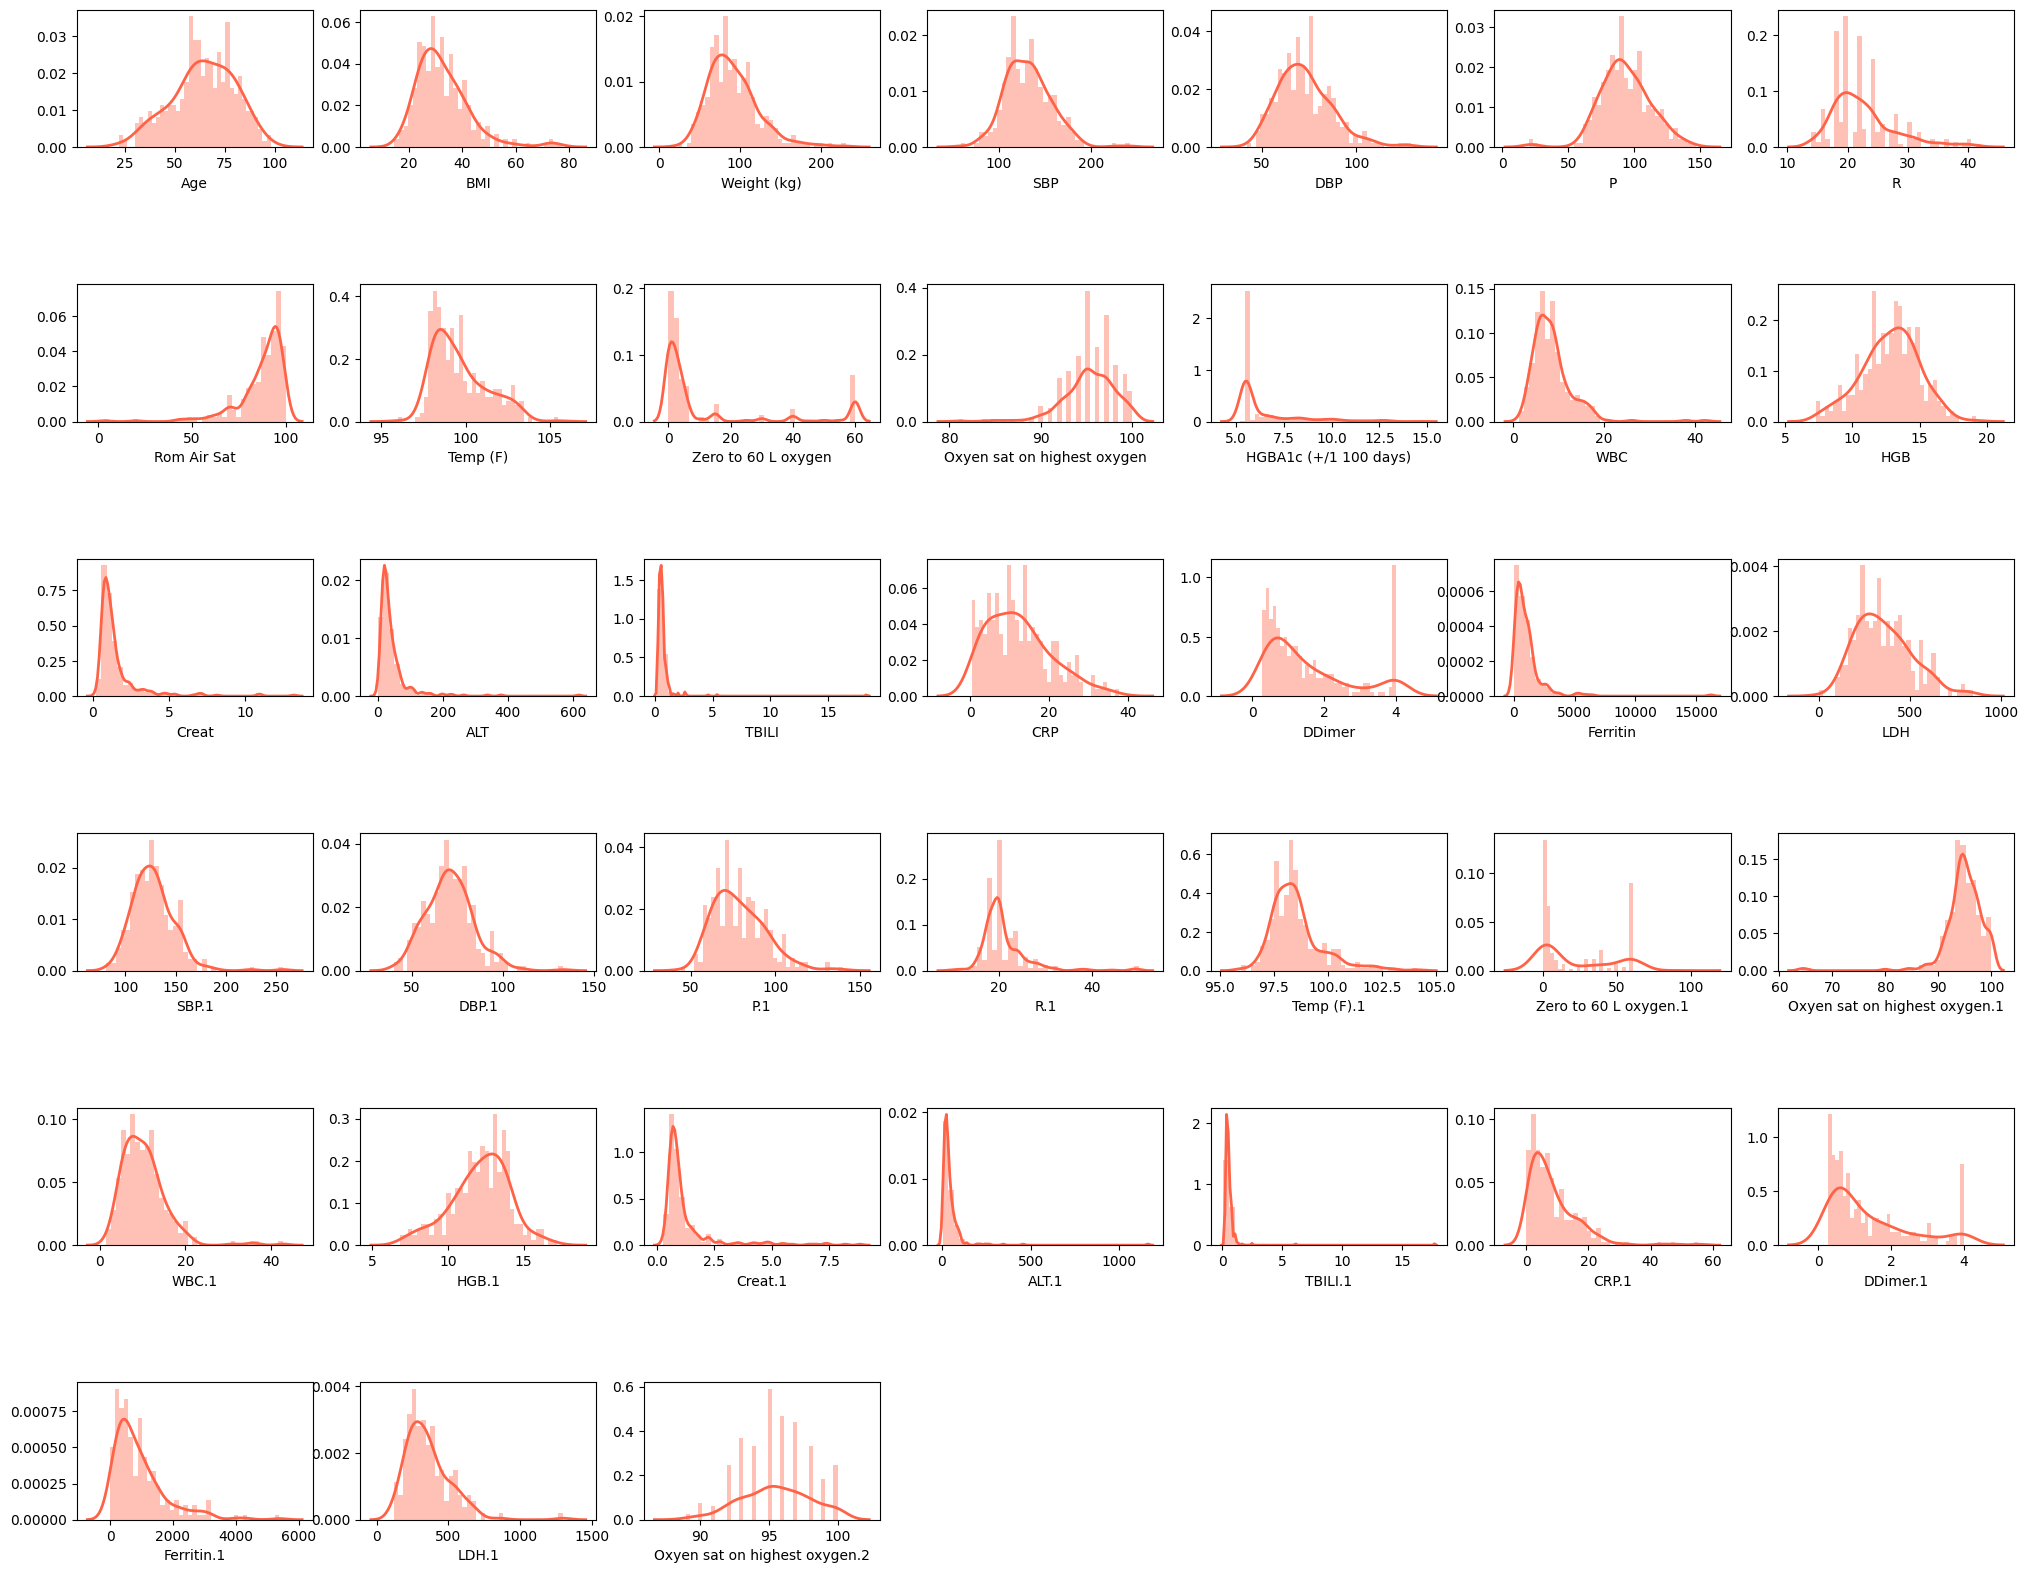

In [92]:
graphList = ['Age', 'BMI', 'Weight (kg)', 'SBP', 'DBP', 'P', 'R',
               'Rom Air Sat', 'Temp (F)', 'Zero to 60 L oxygen',
               'Oxyen sat on highest oxygen', 'HGBA1c (+/1 100 days)', 'WBC',
               'HGB', 'Creat', 'ALT', 'TBILI', 'CRP', 'DDimer',
               'Ferritin', 'LDH', 'SBP.1', 'DBP.1', 'P.1', 'R.1',
               'Temp (F).1', 'Zero to 60 L oxygen.1', 'Oxyen sat on highest oxygen.1',
               'WBC.1', 'HGB.1', 'Creat.1', 'ALT.1', 'TBILI.1',
               'CRP.1', 'DDimer.1', 'Ferritin.1', 'LDH.1',
                'Oxyen sat on highest oxygen.2']
graphs = plt.figure(figsize=(25,20),dpi=100)
plt.subplots_adjust(hspace=1)
#plt.title('Patient Data Distributions')
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(6,7,k)
    sns.distplot(data[graphList[k-1]], hist=True, kde=True, bins=int(len(data)/8), color = 'tomato', kde_kws={'linewidth': 2})
    #plt.ylabel('Frequency')
    #plt.title(graphList[k-1] + ' distribution')

Display some pie charts to visualize the binary data.

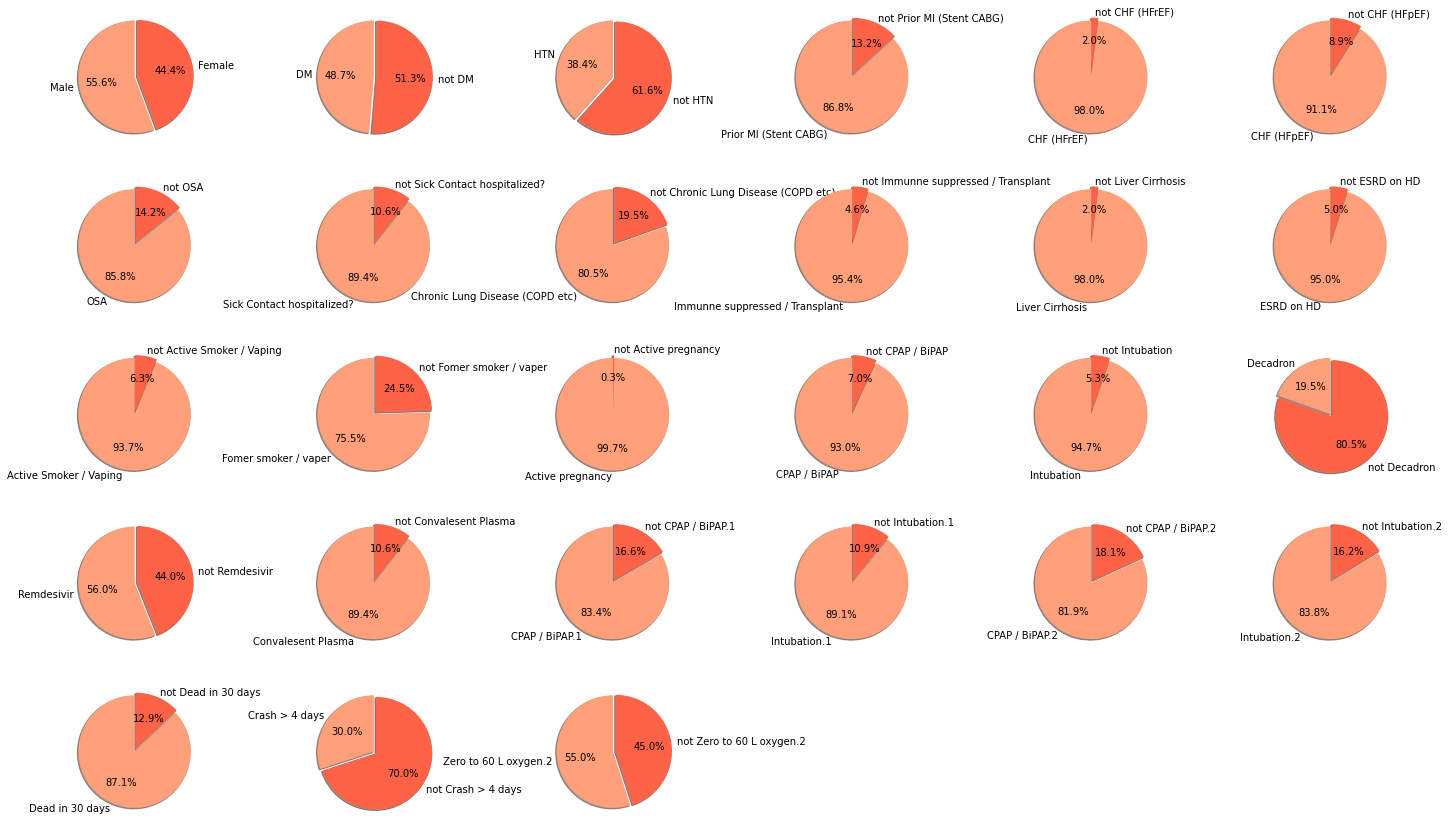

In [93]:
pieList = ['DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
'OSA','Sick Contact hospitalized?','Chronic Lung Disease (COPD etc)','Immunne suppressed / Transplant',
'Liver Cirrhosis','ESRD on HD', 'Active Smoker / Vaping', 'Fomer smoker / vaper', 'Active pregnancy',
'CPAP / BiPAP','Intubation','Decadron','Remdesivir','Convalesent Plasma', 'CPAP / BiPAP.1', 'Intubation.1',
'CPAP / BiPAP.2','Intubation.2','Dead in 30 days','Crash > 4 days', 'Zero to 60 L oxygen.2']
pie = plt.figure(figsize=(25,15))

pie.add_subplot(5,6,1)
sizes = [data.loc[data['Sex'] == False].shape[0], data.loc[data['Sex'] == True].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Male', 'Female'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

for i in range(len(pieList)):
  pie.add_subplot(5,6, i+2)
  sizes = [data.loc[data[pieList[i]] == False].shape[0], data.loc[data[pieList[i]] == True].shape[0]]
  plt.pie(sizes, explode = (0,.05), labels=[pieList[i], "not " + pieList[i]], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

Specifying the factors that we want to consider in this application and what value we are trying to solve for (input X and output Y).

In [101]:
inputColumns = ['Age','Sex','DM','HTN','Prior MI (Stent CABG)','CHF (HFrEF)','CHF (HFpEF)',
                'OSA', 'Sick Contact hospitalized?', 'Chronic Lung Disease (COPD etc)',
                'Immunne suppressed / Transplant', 'Liver Cirrhosis','ESRD on HD','Active Smoker / Vaping',
                'Fomer smoker / vaper','Active pregnancy', 'BMI', 'Weight (kg)','SBP','DBP','P', 'R',
                'Rom Air Sat', 'Temp (F)', 'Zero to 60 L oxygen', 'Oxyen sat on highest oxygen',
                'CPAP / BiPAP', 'Intubation', 'HGBA1c (+/1 100 days)','WBC','HGB','Creat','ALT','TBILI',
                'CRP','DDimer', 'Ferritin', 'LDH', 'Decadron', 'Remdesivir', 'Convalesent Plasma']
#outputColumn = 'Oxygen>30'
outputColumn = 'Zero to 60 L oxygen.2'

inputData = data[inputColumns]
outputData = data[outputColumn]

print(inputData)
print(outputData)

      Age    Sex     DM    HTN  ...    LDH  Decadron  Remdesivir  Convalesent Plasma
0    46.0  False  False  False  ...  375.0      True        True               False
1    50.0  False  False  False  ...  621.0      True        True               False
2    85.0  False   True   True  ...    NaN     False       False               False
3    82.0  False   True  False  ...    NaN      True        True               False
4    66.0   True  False  False  ...    NaN      True       False               False
..    ...    ...    ...    ...  ...    ...       ...         ...                 ...
297  67.0  False   True  False  ...  498.0      True       False               False
298  82.0   True  False   True  ...  325.0      True       False               False
299  66.0  False  False  False  ...  158.0      True        True               False
300  73.0   True  False  False  ...  221.0     False       False               False
301  40.0  False   True  False  ...  175.0      True       False 

Split the data into a testing set and a training set. For the split,

In [102]:
inputTrain, inputTest, outputTrain, outputTest = train_test_split(inputData, outputData, test_size = .3, random_state = 2)
print(inputTrain.shape)
print(inputTest.shape)
print(outputTrain.shape)
print(outputTest.shape)

print(inputTrain)
print(outputTrain)

(211, 41)
(91, 41)
(211,)
(91,)
      Age    Sex     DM    HTN  ...    LDH  Decadron  Remdesivir  Convalesent Plasma
280  38.0  False  False  False  ...  578.0     False       False               False
225  37.0  False  False  False  ...  478.0      True        True               False
109  79.0  False   True  False  ...  234.0      True       False               False
64   80.0   True   True   True  ...  437.0      True       False               False
14   77.0  False   True   True  ...  394.0      True       False               False
..    ...    ...    ...    ...  ...    ...       ...         ...                 ...
75   80.0   True  False   True  ...  273.0      True       False               False
22   53.0   True   True   True  ...  822.0      True       False               False
72   44.0   True   True  False  ...  271.0     False       False               False
15   57.0  False   True  False  ...    NaN     False       False               False
168  82.0  False   True   True  .

Store the data into matricies that can be used in training models

In [103]:
trainMatrix = xgb.DMatrix(inputTrain, label=outputTrain, feature_names=inputColumns[:46])
testMatrix = xgb.DMatrix(inputTest, label=outputTest, feature_names=inputColumns[:46])

Find the best parameters for training the model via cross validation. This step takes time

In [ ]:
#param_grid = {'eta':[.3,.25,.2,.15,0.1,.075,0.05,0.01,0.005,0.001], 'max_depth':np.arange(1,10,1).tolist(), 'subsample':np.arange(1,0.1,-0.1).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.1).tolist(), 'min_child_weight':np.arange(1,100,5).tolist()}
param_grid = {'eta':[.3,.25,.2,.15,0.1,.075,0.05,0.01,0.005,0.001], 'max_depth':np.arange(1,10,5).tolist(), 'subsample':np.arange(1,0.1,-0.5).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.5).tolist(), 'min_child_weight':np.arange(1,100,50).tolist()}
bestParams = {}
lowestError = 2048

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:
                    cvResults = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}, trainMatrix, num_boost_round=600, seed=2, nfold=5, early_stopping_rounds=125)
                    if abs(cvResults['test-{}-mean'.format('error')]).min() < lowestError:
                        lowestError = abs(cvResults['test-{}-mean'.format('error')]).min()
                        bestParams = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}
                    print(str(abs(cvResults['test-{}-mean'.format('error')]).min()) + ' , ' + str(lowestError))
print(bestParams)
print(lowestError)

Train a model using the parameters that we previously found

In [ ]:
model = xgb.train(bestParams, trainMatrix, 5000, evals=[(testMatrix, "Test")], early_stopping_rounds=1000)

Save the model for future use. Change the filepath accordingly (REMEMBER TO CHANGE THE NAME OF THE MODEL SO AN EXISTING MODEL ISNT OVERWRITTEN)

In [ ]:
model.save_model('/content/drive/My Drive/COVID19 ML/9-6-20-1.model')

Output the results of the trained model including a confusion matrix and the importance chart

In [ ]:
outputTrainPredict = model.predict(trainMatrix)
outputTestPredict = model.predict(testMatrix)

print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\n\t   Predicted")
print(pd.crosstab(outputTest, outputTestPredict.round()))
#print(outputTest)
#print(abs(outputTestPredict.round()))

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0


for i in range(len(outputTest)):
  if outputTest.values[i] == True and outputTestPredict.round()[i] == 1:
    truePositive = truePositive + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 0:
    trueNegative = trueNegative + 1
  elif outputTest.values[i] == True and outputTestPredict.round()[i] == 0:
    falseNegative = falseNegative + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 1:
    falsePositive = falsePositive + 1
print("\nTrue Positives: " + str(truePositive))
print("True Negatives: " + str(trueNegative))
print("False Negatives: " + str(falseNegative))
print("False Positives: " + str(falsePositive))
print("Sensitivity: " + str(truePositive / (truePositive + falseNegative)))
print("Specificity: " + str(trueNegative / (trueNegative + falsePositive)))
print("Positive Predictive Value: " + str(truePositive / (truePositive + falsePositive)))
print("Negative Predictive Value: " + str(falsePositive / (falsePositive + truePositive)))

fig, ax = plt.subplots(figsize=(15,12))
xgb.plot_importance(model, ax=ax)


Load a pre-trained model from file.

In [1]:
bst = xgb.Booster()
bst.load_model('/content/drive/My Drive/COVID19 ML/9-5-20-1.model')

outputTrainPredict = bst.predict(trainMatrix)
outputTestPredict = bst.predict(testMatrix)

#print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
#print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\n\t   Predicted")
print(pd.crosstab(outputTest, outputTestPredict.round()))
#print(outputTest)
#print(abs(outputTestPredict.round()))

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0


for i in range(len(outputTest)):
  if outputTest.values[i] == True and outputTestPredict.round()[i] == 1:
    truePositive = truePositive + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 0:
    trueNegative = trueNegative + 1
  elif outputTest.values[i] == True and outputTestPredict.round()[i] == 0:
    falseNegative = falseNegative + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 1:
    falsePositive = falsePositive + 1
print("\nTrue Positives: " + str(truePositive))
print("True Negatives: " + str(trueNegative))
print("False Negatives: " + str(falseNegative))
print("False Positives: " + str(falsePositive))
print("Positve Predicted Rate: " + str(truePositive / (truePositive + falseNegative)))
print("Negative Predicted Rate: " + str(trueNegative / (trueNegative + falsePositive)) + "\n")

fig, ax = plt.subplots(figsize=(15,12))
xgb.plot_importance(bst, ax=ax)

NameError: ignored

Enter our own data into a trained model.

In [ ]:
dataList = []

dataList.append(int(input("Enter Age: ")))
gender = input("Enter Gender (M or F): ")
if gender == "F" or gender == "f": dataList.append(True)
elif gender == "M" or gender == "m": dataList.append(False)
else: sys.exit("invalid input")
dataList.append(int(input("Enter Zip Code: ")))
dataList.append(float(input("Enter BMI: ")))
dataList.append(float(input("Enter Weight: ")))
dataList.append(float(input("Enter Oxygen: ")))
dataList.append(float(input("Enter CRP: ")))
dataList.append(float(input("Enter DDimer: ")))
dataList.append(float(input("Enter Ferritin: ")))
dataList.append(float(input("Enter LDH: ")))
dataList.append(float(input("Enter Oxygen2: ")))
dataList.append(float(input("Enter CRP2: ")))
dataList.append(float(input("Enter DDimer2: ")))
dataList.append(float(input("Enter Ferritin2: ")))
dataList.append(float(input("Enter LDH2: ")))

#dataList = [61,	False,	95823,	31.63,	81,	40,	16.3,	1.43,	1397,	442,	60,	6.9,	0.6,	1380,	528]
df2 = pd.DataFrame(np.array([dataList]),)
exampleMatrix = xgb.DMatrix(df2, label=outputTrain, feature_names=inputColumns[:15])
exampleResult = model.predict(exampleMatrix).round()
if exampleResult == 1:
  print("Predicted Result: Oxygen") 
else:
  print("Predicted Result: No Oxygen")

In case we need to run this from google colab instead of locally, run this box that contains all the final bits of code. Finding the correct parameters will take several hours and if the next box is not run directly afterwards, the runtime can disconnect and the model wont get saved. Remember to change the name of the saved file.

In [ ]:
param_grid = {'eta':[.3,.25,.2,.15,0.1,.075,0.05,0.01,0.005,0.001], 'max_depth':np.arange(1,10,1).tolist(), 'subsample':np.arange(1,0.1,-0.1).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.1).tolist(), 'min_child_weight':np.arange(1,100,5).tolist()}
#param_grid = {'eta':[.075], 'max_depth':np.arange(1,10,5).tolist(), 'subsample':np.arange(1,0.1,-0.5).tolist(), 'colsample_bytree':np.arange(1,0.1,-0.5).tolist(), 'min_child_weight':np.arange(1,100,50).tolist()}
bestParams = {}
lowestError = 2048

for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:
                    cvResults = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}, trainMatrix, num_boost_round=600, seed=2, nfold=5, early_stopping_rounds=125)
                    if abs(cvResults['test-{}-mean'.format('error')]).min() < lowestError:
                        lowestError = abs(cvResults['test-{}-mean'.format('error')]).min()
                        bestParams = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric': 'error'}
                    print(str(abs(cvResults['test-{}-mean'.format('error')]).min()) + ' , ' + str(lowestError))
print(bestParams)
print(lowestError)

model = xgb.train(bestParams, trainMatrix, 5000, evals=[(testMatrix, "Test")], early_stopping_rounds=1000)

model.save_model('/content/drive/My Drive/COVID19 ML/9-23-20-24Eric.model')

outputTrainPredict = model.predict(trainMatrix)
outputTestPredict = model.predict(testMatrix)

print("Training Accuracy: " + str(accuracy_score(outputTrain, outputTrainPredict.round())))
print("Testing Accuracy: " + str(accuracy_score(outputTest, outputTestPredict.round())) + "\n")

print(classification_report(outputTest, outputTestPredict.round()))
print("\n\t   Predicted")
print(pd.crosstab(outputTest, outputTestPredict.round()))
#print(outputTest)
#print(abs(outputTestPredict.round()))

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0


for i in range(len(outputTest)):
  if outputTest.values[i] == True and outputTestPredict.round()[i] == 1:
    truePositive = truePositive + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 0:
    trueNegative = trueNegative + 1
  elif outputTest.values[i] == True and outputTestPredict.round()[i] == 0:
    falseNegative = falseNegative + 1
  elif outputTest.values[i] == False and outputTestPredict.round()[i] == 1:
    falsePositive = falsePositive + 1
print("\nTrue Positives: " + str(truePositive))
print("True Negatives: " + str(trueNegative))
print("False Negatives: " + str(falseNegative))
print("False Positives: " + str(falsePositive))
print("Sensitivity: " + str(truePositive / (truePositive + falseNegative)))
print("Specificity: " + str(trueNegative / (trueNegative + falsePositive)))
print("Positive Predictive Value: " + str(truePositive / (truePositive + falsePositive)))
print("Negative Predictive Value: " + str(falsePositive / (falsePositive + truePositive)))

fig, ax = plt.subplots(figsize=(15,12))
xgb.plot_importance(model, ax=ax)


Streaming output truncated to the last 5000 lines.
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.2276856 , 0.19457359999999999
0.27995559999999997 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.25149499999999997 , 0.19457359999999999
0.2657806 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0.4504982 , 0.19457359999999999
0